In [1]:
import os
import numpy as np
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Veri Yolları
data_dir = "C:\\Users\\abdul\\Desktop\\Cataract\\dataset"
categories = ["immature", "mature"]

# Görüntü Boyutu ve Model Yolu
target_size = (128, 128)
model_path = "trained_cataract_model.h5"

In [3]:
# Veri Yükleme ve Ayrım
def load_and_split_data(data_dir, categories, test_size=0.2):
    images = []
    labels = []
    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        for file in os.listdir(category_path):
            file_path = os.path.join(category_path, file)
            try:
                img = Image.open(file_path).convert("RGB")
                img_resized = img.resize(target_size)
                images.append(np.array(img_resized))
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")
    
    images = np.array(images) / 255.0
    labels = np.array(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, stratify=labels, random_state=42)
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = load_and_split_data(data_dir, categories)

In [6]:
# Model Eğitimi
if not os.path.exists(model_path):
    from tensorflow.keras.applications import MobileNetV2
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


    # Augmentation ve Normalizasyon
    train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True
    )
    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

    # MobileNetV2 Modeli
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    # Modeli Eğit
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=test_generator,
        callbacks=[early_stopping, reduce_lr]
    )
    model.save(model_path)
    print("Model eğitildi ve kaydedildi.")
else:
    model = load_model(model_path)
    print("Eğitilmiş model yüklendi.")

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 479ms/step - accuracy: 0.6186 - loss: 5.8973 - val_accuracy: 0.9390 - val_loss: 4.9045 - learning_rate: 1.0000e-04
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.8511 - loss: 5.0499 - val_accuracy: 0.9512 - val_loss: 4.6301 - learning_rate: 1.0000e-04
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.9077 - loss: 4.7030 - val_accuracy: 0.9512 - val_loss: 4.3637 - learning_rate: 1.0000e-04
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - accuracy: 0.9118 - loss: 4.5206 - val_accuracy: 0.9634 - val_loss: 4.1380 - learning_rate: 1.0000e-04
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - accuracy: 0.9368 - loss: 4.1676 - val_accuracy: 0.9634 - val_loss: 3.9636 - learning_rate: 1.0000e-04
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - accuracy: 0.8954 - loss: 4.0643 - val_accuracy: 0.9512 - val_loss: 3.8348 - learning_rate: 1.0000e-04
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - ac

Model eğitildi ve kaydedildi.


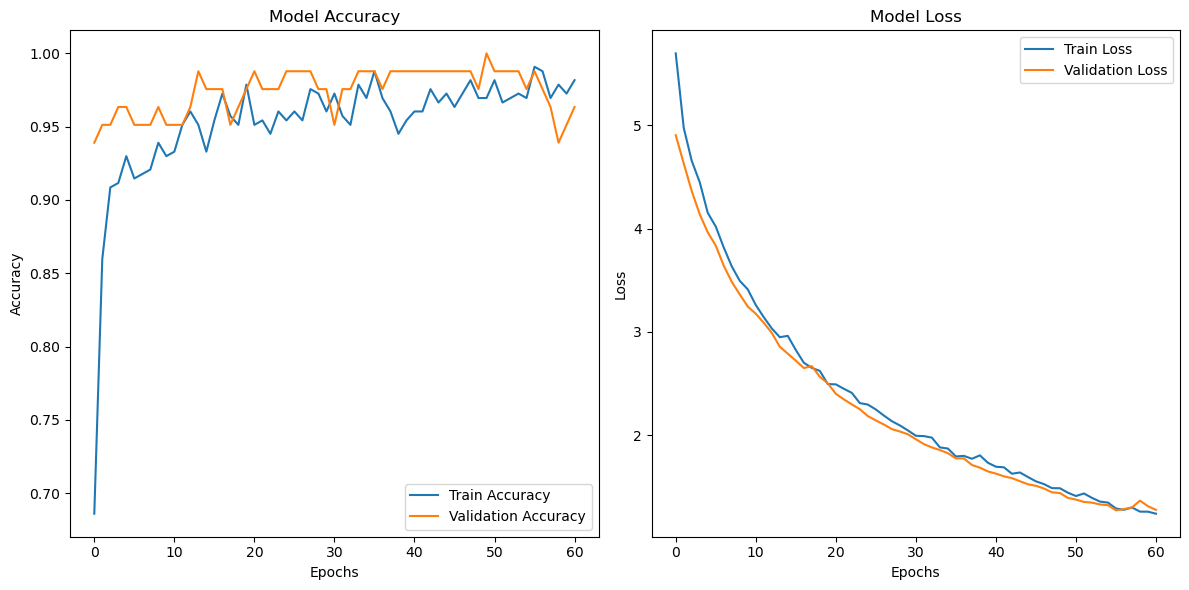

In [7]:
# Eğitim Süreci Grafikleri
if 'history' in locals() or 'history' in globals():
    plt.figure(figsize=(12, 6))

    # Doğruluk
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Kayıp
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
# Test Verisinde Tahmin
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 591ms/step


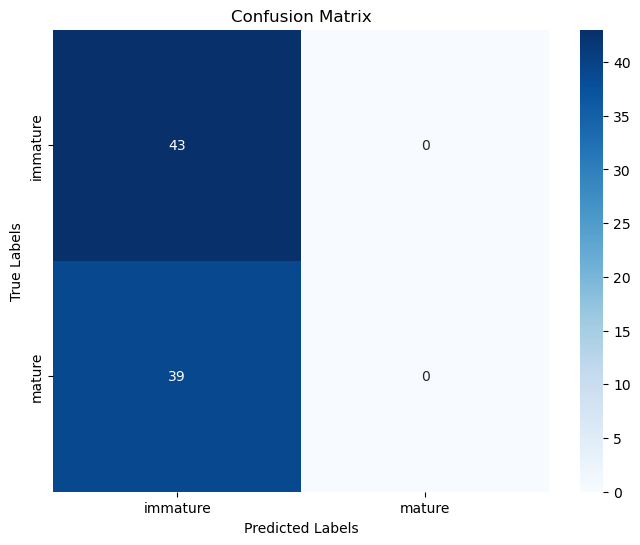

Classification Report:
              precision    recall  f1-score   support

    immature       0.52      1.00      0.69        43
      mature       0.00      0.00      0.00        39

    accuracy                           0.52        82
   macro avg       0.26      0.50      0.34        82
weighted avg       0.27      0.52      0.36        82



c:\Users\abdul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abdul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abdul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
# Karmaşıklık Matrisi ve Sınıflandırma Raporu
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


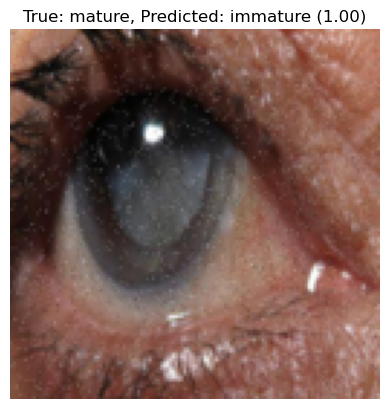

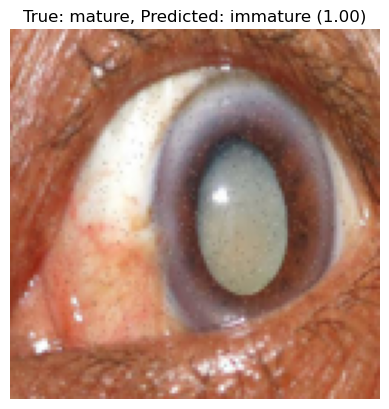

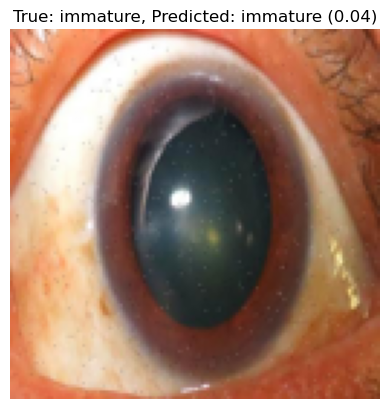

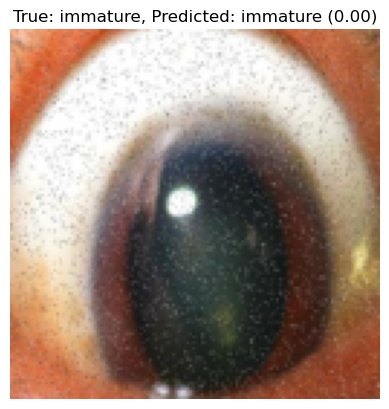

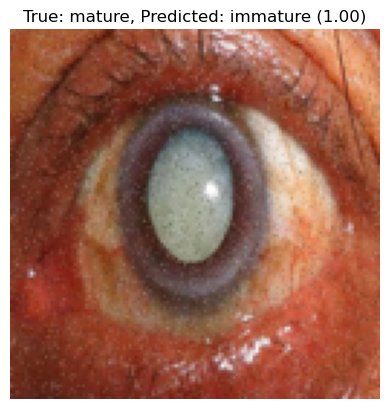

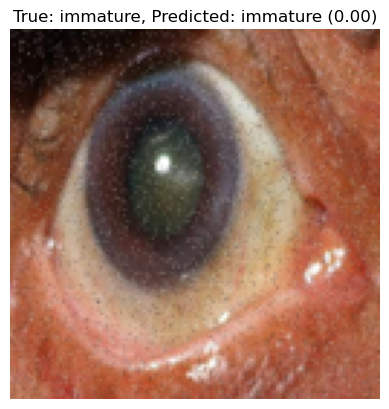

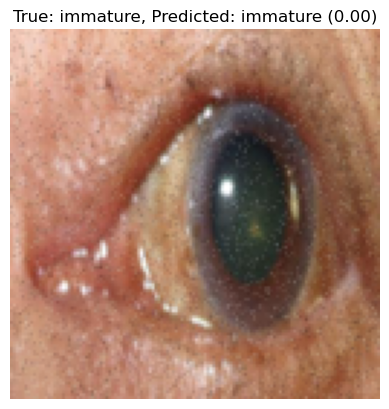

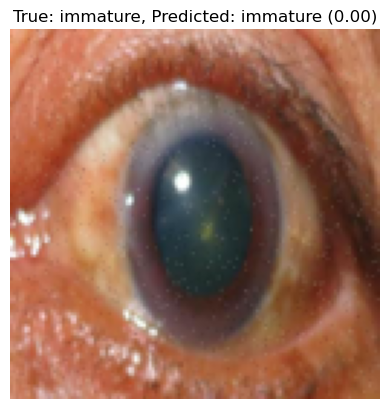

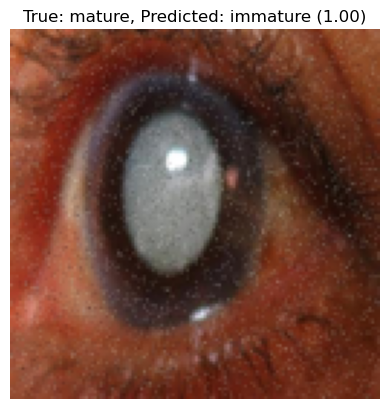

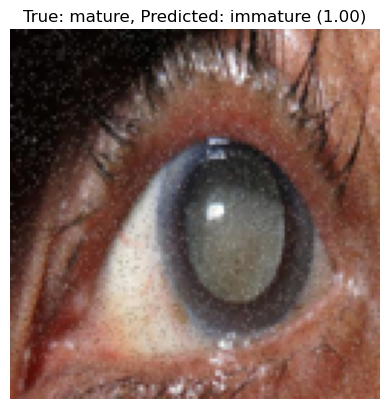

In [10]:
# Rastgele 10 Test Görüntüsü Tahmini ve Görselleştirme
def predict_and_show_images(model, X_test, y_test, categories, n_images=10):
    indices = random.sample(range(len(X_test)), n_images)
    images = X_test[indices]
    true_labels = y_test[indices]

    predictions = model.predict(images)
    for i, pred in enumerate(predictions):
        true_label = categories[true_labels[i]]
        pred_label = categories[np.argmax(pred)]
        confidence = np.max(pred)

        plt.figure()
        plt.imshow(images[i])
        plt.title(f"True: {true_label}, Predicted: {pred_label} ({confidence:.2f})")
        plt.axis('off')
        plt.show()

predict_and_show_images(model, X_test, y_test, categories)

In [12]:
model0 = load_model(model_path)

In [1]:
#tahmin fonksiyonu
from tensorflow.keras.preprocessing import image
def predict_cataract(img_path, model):

    # Test görselini yükleyin ve ön işleme yapın
    img = image.load_img(img_path, target_size=(128, 128))  # Resmi uygun boyuta getir

    # Görseli numpy array'e dönüştür
    img_array = image.img_to_array(img)

    # Normalize et
    img_array = img_array / 255.0  # Eğer eğitimde normalize ettiyseniz

    # Modelin input formatına uygun hale getirin (bir batch olarak)
    img_array = np.expand_dims(img_array, axis=0)

    # Modelin tahminini yapın
    predictions = model.predict(img_array)

    # Tahmin sonuçları
    predicted_class = np.argmax(predictions, axis=-1)

    # Çıktı sınıfını yorumlayın
    if predicted_class == 0:
        return "Normal  Göz"
    else:
        return "Katarakt Var"